# our imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pickle
from tqdm import tqdm

# transforms for the images

In [2]:
# the transformations we will implement on our dataset at the beginning of loading them:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # flips the image w.r.t horizontal axis
    #transforms.RandomRotation(10), # rotates the image to a specified angel
    #transforms.RandomAutocontrast(),
    #transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # performs actions like zooms, change shear angles
    #transforms.RandomPerspective(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # set the color params
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# the device on which our codes will run:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# downloading the dataset

In [3]:
# we produce our original dataset. we don't use dataloader, because we like to be able to...
# ...modify the data in any way we please.

# download CIFAR10 dataset:

train_set = torchvision.datasets.CIFAR10(root='data/', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='data/', train=False, download=True, transform=transforms_test)

Files already downloaded and verified
Files already downloaded and verified


# extracting images/data from set object

In [4]:
# save all datapoints in numpy arrays for later uses:

x_train = np.array([np.array(datapoint[0]) for datapoint in train_set])
y_train = np.array([np.array(datapoint[1]) for datapoint in train_set])

x_test = np.array([np.array(datapoint[0]) for datapoint in test_set])
y_test = np.array([np.array(datapoint[1]) for datapoint in test_set])

print(f'{x_train.shape = }')
print(f'{y_train.shape = }')

print(f'{x_test.shape = }')
print(f'{y_test.shape = }')

x_train.shape = (50000, 3, 32, 32)
y_train.shape = (50000,)
x_test.shape = (10000, 3, 32, 32)
y_test.shape = (10000,)


# extracting the index of the cat in labels' file

In [5]:
# cat: 3
# frog: 6

label_names_file = open('data/cifar-10-batches-py/batches.meta', 'rb')
label_names = pickle.load(label_names_file)
label_names_file.close()

print(label_names)

{'num_cases_per_batch': 10000, 'label_names': ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], 'num_vis': 3072}


# indices of cat data

In [6]:
# get indices of cats in train and test sets:

indices_cats_train = np.where(y_train == 3)[0]
indices_cats_test = np.where(y_test == 3)[0]

print(indices_cats_train.shape)
print(indices_cats_test.shape)

(5000,)
(1000,)


# separating cat data from the rest

In [7]:
# separate cats from train and test sets:

x_train_cat = x_train[indices_cats_train, :, :, :]
y_train_cat = y_train[indices_cats_train]

x_test_cat = x_test[indices_cats_test, :, :, :]
y_test_cat = y_test[indices_cats_test]

print(f'{x_train_cat.shape = }')
print(f'{y_train_cat.shape = }')

print(f'{x_test_cat.shape = }')
print(f'{y_test_cat.shape = }')

print(np.unique(y_train_cat))

x_train_cat.shape = (5000, 3, 32, 32)
y_train_cat.shape = (5000,)
x_test_cat.shape = (1000, 3, 32, 32)
y_test_cat.shape = (1000,)
[3]


In [8]:
# training and test data without cats:

x_train_without_cat = np.delete(x_train, indices_cats_train, axis=0)
y_train_without_cat = np.delete(y_train, indices_cats_train)

x_test_without_cat = np.delete(x_test, indices_cats_test, axis=0)
y_test_without_cat = np.delete(y_test, indices_cats_test)


print(f'{x_train_without_cat.shape = }')
print(f'{y_train_without_cat.shape = }')

print(f'{x_test_without_cat.shape = }')
print(f'{y_test_without_cat.shape = }')

print(np.unique(y_train_without_cat))

x_train_without_cat.shape = (45000, 3, 32, 32)
y_train_without_cat.shape = (45000,)
x_test_without_cat.shape = (9000, 3, 32, 32)
y_test_without_cat.shape = (9000,)
[0 1 2 4 5 6 7 8 9]


# fixing the order in labels so the CUDA DSA error won't be thrown at us

In [9]:
# now, we assign class 3 (previously cat) to truck:

indices = np.where(y_train_without_cat == 9)[0]
y_train_without_cat[indices] = 3

indices = np.where(y_test_without_cat == 9)[0]
y_test_without_cat[indices] = 3

print(np.unique(y_train_without_cat))

print(np.unique(y_test_without_cat))

[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]


# creating validation data

In [10]:
# split the datapoints into train (10%) and test (90%):

x_train_without_cat, x_valid_without_cat, y_train_without_cat, y_valid_without_cat = train_test_split(x_train_without_cat, y_train_without_cat, test_size=0.1, stratify=y_train_without_cat, shuffle=True)

print(f'{x_train_without_cat.shape = }')
print(f'{y_train_without_cat.shape = }')

print(f'{x_valid_without_cat.shape = }')
print(f'{y_valid_without_cat.shape = }')

x_train_without_cat.shape = (40500, 3, 32, 32)
y_train_without_cat.shape = (40500,)
x_valid_without_cat.shape = (4500, 3, 32, 32)
y_valid_without_cat.shape = (4500,)


# creating dataloader for each phases of learning

In [11]:
# convert our numpy arrays to torch tensor and create dataset and data loader from them:

x_train_without_cat = torch.from_numpy(x_train_without_cat)
y_train_without_cat = torch.from_numpy(y_train_without_cat)

x_valid_without_cat = torch.from_numpy(x_valid_without_cat)
y_valid_without_cat = torch.from_numpy(y_valid_without_cat)

x_test_without_cat = torch.from_numpy(x_test_without_cat)
y_test_without_cat = torch.from_numpy(y_test_without_cat)

# convert torch tensor to torch dataset and then torch data loader:

train_set = TensorDataset(x_train_without_cat, y_train_without_cat)
valid_set = TensorDataset(x_valid_without_cat, y_valid_without_cat)
test_set = TensorDataset(x_test_without_cat, y_test_without_cat)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

# creating our model, optimizer and learning rate scheduler objects

In [12]:
# creating our model, optimizer and learning rate scheduler objects
# the implementation of ResNet18 is taken from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=9):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [13]:
'''
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(512, 9)
model = model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
''';

In [14]:
model = ResNet18()
model = model.to(device)

optimizer = optim.Adam(params=model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=5e-4)

criterion = nn.CrossEntropyLoss()

lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# training and evaluation process

In [15]:
epochs = 200

# lists to keep track of losses and accuracies during training:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

for epoch in range(1, epochs + 1):
    # a counter to efficiently calculate loss:
    counter = 0
    
    # set the model on training mode, so the gradients can be updated:
    model.train()
    
    print(f'Epoch {epoch} of {epochs}')
    
    # to calculate loss and accuracy for whole epoch:
    train_running_loss = 0.0
    train_running_correct = 0
    
    for data, labels in train_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # preparing for training and validation:
        optimizer.zero_grad()
        
        # forward-pass:
        output = model(data)
        
        # calculating the loss:
        loss = criterion(output, labels)
        
        # backpropagation:
        loss.backward()
        
        # updating the weights:
        optimizer.step()
        
        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        train_running_loss += loss.item()

    # training loss and accuracy for the whole epoch:
    epoch_train_loss = train_running_loss / counter
    epoch_train_acc = 100.0 * (train_running_correct / len(train_loader.dataset))
    
    print(f'Training Loss: {epoch_train_loss:.3f}, Training Accuracy: {epoch_train_acc:.3f}')
    
    # set the model to evaluation mode:
    model.eval()
    
    # we don't want gradients being updated:
    with torch.no_grad():
        # loss and accuracy for whole validation or test set:
        valid_running_loss = 0.0
        valid_running_correct = 0

        # a counter to efficiently calculate loss:
        counter = 0
        
        for data, labels in valid_loader:
            counter += 1
            
            # read data and labels, and move them to gpu:
            data = data.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            
            # forward-pass:
            output = model(data)
            
            # calculating the loss:
            loss = criterion(output, labels)

            # calculating the accuracy for the epoch:
            _, preds = torch.max(output.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            
            # calculating the loss for the epoch:
            valid_running_loss += loss.item()

        # loss and accuracy for the whole epoch:
        epoch_valid_loss = valid_running_loss / counter
        epoch_valid_acc = 100.0 * (valid_running_correct / len(valid_loader.dataset))
        
        print(f'Validation Loss: {epoch_valid_loss:.3f}, Validation Accuracy: {epoch_valid_acc:.3f}')
        
        print('-' * 50)
        
    lr_scheduler.step()   
    
    # save results in corresponding lists:
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    valid_loss.append(epoch_valid_loss)
    valid_acc.append(epoch_valid_acc)

Epoch 1 of 200
Training Loss: 1.390, Training Accuracy: 48.272
Validation Loss: 1.381, Validation Accuracy: 53.222
--------------------------------------------------
Epoch 2 of 200
Training Loss: 0.882, Training Accuracy: 68.659
Validation Loss: 1.002, Validation Accuracy: 65.667
--------------------------------------------------
Epoch 3 of 200
Training Loss: 0.677, Training Accuracy: 76.237
Validation Loss: 0.882, Validation Accuracy: 71.044
--------------------------------------------------
Epoch 4 of 200
Training Loss: 0.538, Training Accuracy: 81.343
Validation Loss: 0.612, Validation Accuracy: 78.533
--------------------------------------------------
Epoch 5 of 200
Training Loss: 0.438, Training Accuracy: 84.751
Validation Loss: 0.682, Validation Accuracy: 76.511
--------------------------------------------------
Epoch 6 of 200
Training Loss: 0.360, Training Accuracy: 87.467
Validation Loss: 0.768, Validation Accuracy: 76.956
--------------------------------------------------
Epoc

Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.592, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 51 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.585, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 52 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.595, Validation Accuracy: 88.422
--------------------------------------------------
Epoch 53 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.592, Validation Accuracy: 88.533
--------------------------------------------------
Epoch 54 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.588, Validation Accuracy: 88.600
--------------------------------------------------
Epoch 55 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.589, Validation Accuracy: 88.400
--------------------------------------------------
Epoch 56

Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.595, Validation Accuracy: 88.556
--------------------------------------------------
Epoch 100 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.593, Validation Accuracy: 88.533
--------------------------------------------------
Epoch 101 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.593, Validation Accuracy: 88.333
--------------------------------------------------
Epoch 102 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.594, Validation Accuracy: 88.489
--------------------------------------------------
Epoch 103 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.605, Validation Accuracy: 88.489
--------------------------------------------------
Epoch 104 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.592, Validation Accuracy: 88.467
--------------------------------------------------
Epo

Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.587, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 149 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.589, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 150 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.593, Validation Accuracy: 88.556
--------------------------------------------------
Epoch 151 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.593, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 152 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.596, Validation Accuracy: 88.400
--------------------------------------------------
Epoch 153 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.589, Validation Accuracy: 88.422
--------------------------------------------------
Epo

Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.594, Validation Accuracy: 88.378
--------------------------------------------------
Epoch 198 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.598, Validation Accuracy: 88.578
--------------------------------------------------
Epoch 199 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.588, Validation Accuracy: 88.444
--------------------------------------------------
Epoch 200 of 200
Training Loss: 0.000, Training Accuracy: 100.000
Validation Loss: 0.593, Validation Accuracy: 88.400
--------------------------------------------------


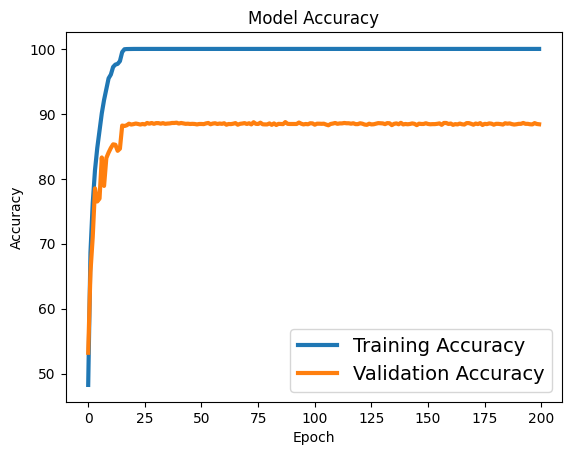

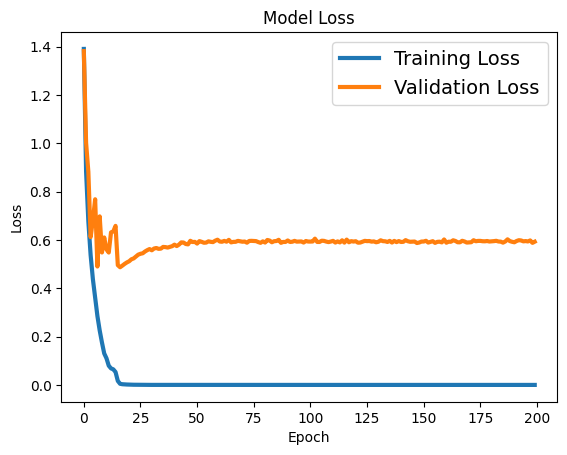

In [16]:
# plot accuracy progress for both training and validation:

plt.plot(train_acc, label='Training Accuracy', linewidth=3)
plt.plot(valid_acc, label='Validation Accuracy', linewidth=3)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best', fontsize=14)
plt.show()

# plot loss progress for both training and validation:

plt.plot(train_loss, label='Training Loss', linewidth=3)
plt.plot(valid_loss, label='Validation Loss', linewidth=3)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=14)
plt.show()

In [17]:
# evaluate the model on test-set:

# set the model to evaluation mode:
model.eval()

model_outputs = []

with torch.no_grad():
    # loss and accuracy for whole validation or test set:
    test_running_loss = 0.0
    test_running_correct = 0

    # a counter to efficiently calculate loss:
    counter = 0
    
    for data, labels in test_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_outputs += output
        
        # calculating the loss:
        loss = criterion(output, labels)

        # calculating the accuracy for the epoch:
        _, preds = torch.max(output.data, 1)
        test_running_correct += (preds == labels).sum().item()
        
        # calculating the loss for the epoch:
        test_running_loss += loss.item()

    # loss and accuracy for the whole epoch:
    test_loss = test_running_loss / counter
    test_acc = 100.0 * (test_running_correct / len(test_loader.dataset))
    
    print(f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_acc:.3f}')

Test Loss: 0.662, Test Accuracy: 89.100


# saving and loading the model

In [18]:
torch.save(model, 'model without cat.pt')

In [40]:
model = torch.load('model without cat.pt')

# process of saving outputs of the model for original test data

In [41]:
# evaluate the model on test-set:

# set the model to evaluation mode:
model.eval()

model_outputs = []

with torch.no_grad():
    # loss and accuracy for whole validation or test set:
    test_running_loss = 0.0
    test_running_correct = 0

    # a counter to efficiently calculate loss:
    counter = 0
    
    for data, labels in test_loader:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_outputs += output

# passing the outputs of the model through softmax to get the logits

In [42]:
model_outputs = torch.stack(model_outputs, 0)
softmax_logits = F.softmax(model_outputs, 1)

print(softmax_logits)
print(softmax_logits.size())

tensor([[1.9913e-14, 1.3605e-05, 1.4870e-16,  ..., 1.6003e-14, 1.9293e-15,
         9.9999e-01],
        [1.6446e-07, 3.0914e-04, 2.5384e-09,  ..., 1.6707e-10, 9.6646e-11,
         9.9969e-01],
        [7.5247e-01, 7.1461e-07, 2.4421e-01,  ..., 4.4637e-09, 1.8333e-06,
         3.3144e-03],
        ...,
        [8.4012e-15, 9.2225e-14, 3.7211e-12,  ..., 3.3737e-11, 5.3883e-12,
         1.0531e-12],
        [1.2163e-09, 1.0000e+00, 7.2469e-13,  ..., 4.2541e-13, 2.5209e-13,
         2.9683e-11],
        [1.2639e-14, 7.3947e-13, 7.7074e-16,  ..., 2.7906e-19, 1.0000e+00,
         6.8523e-17]], device='cuda:0')
torch.Size([9000, 9])


# getting the maximum probability value in the logits

In [43]:
softmax_logits_max = torch.max(softmax_logits, 1)[0]

print(softmax_logits_max)
print(softmax_logits_max.size())

tensor([1.0000, 0.9997, 0.7525,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')
torch.Size([9000])


# finding a suitable threshold, so that maximum probability above that threshold is considered to be inlier data

In [44]:
threshold = np.percentile(softmax_logits_max.cpu(), 5)
print(threshold)

0.7958381682634353


# checking if we found the threshold correctly

In [45]:
inlier_indices = softmax_logits_max >= threshold
print(inlier_indices)
print(inlier_indices.shape)

print(np.where(inlier_indices.cpu() == True)[0].shape)

print(f'Inlier Percentage = {np.where(inlier_indices.cpu() == True)[0].shape[0] / softmax_logits_max.size(0) * 100}%')

tensor([ True,  True, False,  ...,  True,  True,  True], device='cuda:0')
torch.Size([9000])
(8550,)
Inlier Percentage = 95.0%


# now, creating a dataloader for cats' class

In [46]:
# create dataloader for cats' class:

x_test_cat = torch.from_numpy(x_test_cat)
y_test_cat = torch.from_numpy(y_test_cat)

test_set_cat = TensorDataset(x_test_cat, y_test_cat)
test_loader_cat = DataLoader(test_set_cat, batch_size=128, shuffle=False)

# process of saving outputs of the model for cats' test data

In [47]:
# get the output of model for cats:

# set the model to evaluation mode:
model.eval()

model_ouputs_cat = []

with torch.no_grad():
    for data, labels in test_loader_cat:
        counter += 1
        
        # read data and labels, and move them to gpu:
        data= data.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        
        # forward-pass:
        output = model(data)
        
        model_ouputs_cat += output

# passing the outputs of the model through softmax to get the logits

In [48]:
# get the output of model for cats and pass it through softmax to get cats' logits:

model_ouputs_cat = torch.stack(model_ouputs_cat, 0)
softmax_logit_cats = F.softmax(model_ouputs_cat, 1)

print(softmax_logit_cats)
print(softmax_logit_cats.size())

tensor([[1.3093e-08, 2.5333e-08, 1.9420e-09,  ..., 2.1760e-02, 4.8993e-09,
         4.0491e-08],
        [6.1428e-11, 5.9272e-09, 2.2352e-09,  ..., 1.4266e-05, 1.4914e-05,
         8.3612e-10],
        [1.5701e-10, 8.5326e-09, 2.1992e-05,  ..., 1.2807e-01, 2.3214e-05,
         1.8717e-09],
        ...,
        [3.3972e-12, 1.1887e-09, 8.3366e-12,  ..., 2.5063e-07, 1.4495e-07,
         3.8334e-11],
        [8.2917e-11, 2.6132e-11, 1.1331e-09,  ..., 2.0838e-07, 9.9182e-09,
         4.6170e-11],
        [6.7607e-17, 4.8595e-14, 3.7070e-15,  ..., 8.4444e-07, 6.5780e-11,
         5.1655e-15]], device='cuda:0')
torch.Size([1000, 9])


# getting the maximum probability value in the logits

In [49]:
softmax_logits_cats_max = torch.max(softmax_logit_cats, 1)[0]

print(softmax_logits_cats_max)
print(softmax_logits_cats_max.size())

tensor([0.9782, 0.9882, 0.6182, 0.9798, 1.0000, 0.9313, 0.9232, 0.9999, 0.9259,
        1.0000, 1.0000, 0.9723, 0.9999, 0.9999, 0.9166, 0.5996, 0.9739, 0.9494,
        0.7973, 1.0000, 1.0000, 0.9243, 1.0000, 0.8671, 0.9992, 0.9347, 0.9483,
        0.8007, 1.0000, 0.8883, 0.9998, 0.5101, 0.9521, 0.9024, 0.9957, 0.9993,
        0.7292, 0.6385, 0.7706, 0.4766, 0.9960, 0.9176, 0.9694, 1.0000, 0.9990,
        1.0000, 0.9977, 0.9996, 0.6136, 0.9999, 1.0000, 1.0000, 0.9987, 0.6921,
        0.9319, 0.9452, 0.9998, 0.9999, 0.9999, 0.9997, 0.9997, 0.5229, 0.9577,
        0.9726, 0.9610, 0.9329, 0.6846, 0.6787, 0.9974, 0.9255, 0.9214, 0.9985,
        0.5235, 1.0000, 0.5012, 0.9529, 0.9997, 0.7479, 0.9998, 0.9189, 0.7224,
        0.7383, 0.6527, 0.4719, 0.9876, 1.0000, 0.7096, 1.0000, 0.9923, 0.5028,
        0.9589, 0.9986, 1.0000, 0.9992, 1.0000, 0.8446, 0.5320, 1.0000, 0.4460,
        1.0000, 0.9800, 1.0000, 0.5246, 0.9811, 1.0000, 1.0000, 0.9925, 0.3255,
        1.0000, 1.0000, 0.9974, 0.9879, 

# comparing cats' outlier data and finding a percentage which shows how many cats' data is considered to be outlier

In [50]:
outlier_indices = softmax_logits_cats_max < threshold
print(outlier_indices)
print(outlier_indices.shape)

print(np.where(outlier_indices.cpu() == True)[0].shape)

print(f'Outlier Percentage = {np.where(outlier_indices.cpu() == True)[0].shape[0] / softmax_logits_cats_max.size(0) * 100}%')

tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False,  True, False, False, False, False, False, False,
        False,  True, False, False, False, False,  True,  True, False, False,
        False, False,  True, False,  True, False, False,  True, False, False,
         True,  True,  True,  True, False, False,  True, False, False,  True,
        False, False, False, False, False, False,  True, False,  True, False,
        False, False,  True, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, 